# Run a single model in *pymt*

In this example we will run a single model in *pymt*. We will use the water balance
model, *Hydrotrend* (written in C). We'll setup a model simulation, run it, and then
analyze the output. You will also be given a chance to do your own simulations
and explore the HydroTrend model. 

* [Explore the base-case river simulation](#Exercise-1)
* [How does a river system respond to climate change?](#Exercise-2)

## HydroTrend

HydroTrend is a 2D hydrological water balance and transport model that simulates water
discharge and sediment load at a river outlet. You can read more about the model, find
references or download the source code at: https://csdms.colorado.edu/wiki/Model:HydroTrend.

### River Sediment Supply Modeling

This notebook is meant to give you a better understanding of what the model is capable of. In this
example we are using a theoretical river basin of ~1990 km<sup>2</sup>, with 1200m of relief and
a river length of ~100 km. All parameters that are shown by default once the HydroTrend Model
is loaded are based on a present-day, temperate climate. Whereas these runs are not meant to
be specific, we are using parameters that are realistic for the [Waiapaoa River][map_of_waiapaoa]
in New Zealand. The Waiapaoa River is located on North Island and receives high rain and has
erodible soils, so the river sediment loads are exceptionally high. It has been called the
*"dirtiest small river in the world"*.

To learn more about HydroTrend and its approach to sediment supply modeling, you can download
this [presentation][hydrotrend_presentation].

A more detailed description of applying HydroTrend to the Waipaoa basin, New Zealand has been published in WRR: [hydrotrend_waipaoa_paper]. 

[map_of_waiapaoa]: https://www.google.com/maps/place/Waipaoa+River/@-38.5099042,177.7668002,71814m/data=!3m1!1e3!4m5!3m4!1s0x6d65def908624859:0x2a00ef6165e1dfa0!8m2!3d-38.5392405!4d177.8843782
[hydrotrend_presentation]: https://csdms.colorado.edu/wiki/File:SedimentSupplyModeling02_2013.ppt
[hydrotrend_waipaoa_paper]: http://dx.doi.org/10.1029/2006WR005570

### Exercise
To start, import numpy and matplotlib.


In [1]:
import matplotlib.pyplot as plt
import numpy as np

And load the HydroTrend model.

In [2]:
import pymt.models
hydrotrend = pymt.models.Hydrotrend()

➡ models: Avulsion, Plume, Sedflux3D, Subside, FrostNumber, Ku, Hydrotrend, GIPL, ECSimpleSnow, Cem, Waves, ExponentialWeatherer, Flexure, FlowAccumulator, FlowDirectorD8, FlowDirectorDINF, FlowDirectorSteepest, LinearDiffuser, OverlandFlow, SoilMoisture, StreamPowerEroder, TransportLengthHillslopeDiffuser, Vegetation


HydroTrend will now be activated in PyMT.


## Exercise 1

### Explore the base-case river simulation

For this case study, we will run a simulation for 100 years at daily time-step.
This means you run Hydrotrend for 36,500 days total. Later on we will change
other input parameters but, for now, we'll just stick with the defaults.

In [3]:
import pymt.models
hydrotrend = pymt.models.Hydrotrend()

In [4]:
config_file, config_folder = hydrotrend.setup(run_duration=100)
hydrotrend.initialize(config_file, config_folder)

We can now see that, indeed, we have set up model simulation that will run for
100 years. Notice that HydroTrend has a time step of 1 day so we will be
generating daily hydrographs.

In [5]:
print("Start time: {0} {1}".format(hydrotrend.start_time, hydrotrend.time_units))
print("Current time: {0} {1}".format(hydrotrend.time, hydrotrend.time_units))
print("End time: {0} {1}".format(hydrotrend.end_time, hydrotrend.time_units))
print("Time step: {0} {1}".format(hydrotrend.time_step, hydrotrend.time_units))

Start time: 0.0 d
Current time: 0.0 d
End time: 36500.0 d
Time step: 1.0 d


If we look at HydroTrend's input and output variables, we notice that HydroTrend is
slightly unusual in that there are now input variables. There are lots of output
variables, though.

In [6]:
hydrotrend.input_var_names

()

In [7]:
hydrotrend.output_var_names

('atmosphere_bottom_air__domain_mean_of_temperature',
 'channel_exit_water_sediment~suspended__mass_flow_rate',
 'channel_exit_water_flow__speed',
 'channel_entrance_water_sediment~bedload__mass_flow_rate',
 'channel_exit_water__volume_flow_rate',
 'channel_exit_water_x-section__width',
 'channel_exit_water_x-section__depth',
 'channel_entrance_water__volume_flow_rate',
 'atmosphere_water__domain_mean_of_precipitation_leq-volume_flux',
 'channel_exit_water_sediment~bedload__mass_flow_rate',
 'channel_exit_water_sediment~suspended__mass_concentration')

Of this list of output variables, we're going to track water and sediment discharge, sediment
concentration and bedload flux. The mapping of these variables to the Standard Names
reported by *output_var_names* is given in the following table.

| Conventional Name      | Standard Name                                             |
| :--------------------- | :-------------------------------------------------------- |
| Water discharge        | channel_exit_water__volume_flow_rate                      |
| Sediment discharge     | channel_exit_water_sediment~suspended__mass_flow_rate     |
| Sediment concentration | channel_exit_water_sediment~suspended__mass_concentration |
| Bedload flux           | channel_exit_water_sediment~bedload__mass_flow_rate       |

What do you think? Are you able to figure out what the other output variables are?

We use the ***update*** method to advance *hydrotrend* one time step at a time and the ***get_value***
method to retreive values from the model. Feel free to add other variables if you like.

In [8]:
n_steps = int(hydrotrend.end_time / hydrotrend.time_step)

q = np.empty(n_steps)
qs = np.empty(n_steps)
cs = np.empty(n_steps)
qb = np.empty(n_steps)

for i in range(n_steps):
    hydrotrend.update()
    
    q[i] = hydrotrend.get_value("channel_exit_water__volume_flow_rate")
    qs[i] = hydrotrend.get_value("channel_exit_water_sediment~suspended__mass_flow_rate")
    cs[i] = hydrotrend.get_value("channel_exit_water_sediment~suspended__mass_concentration")
    qb[i] = hydrotrend.get_value("channel_exit_water_sediment~bedload__mass_flow_rate")

Now plot the complete hydrograph.

Text(0, 0.5, 'Sediment discharge')

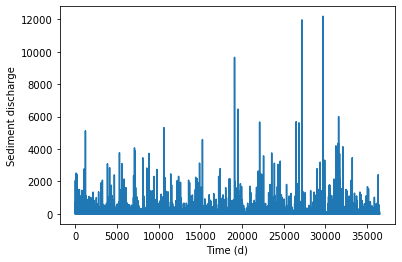

In [9]:
time = np.arange(len(qs))
plt.plot(time, qs)
plt.xlabel("Time ({0})".format(hydrotrend.time_units))
plt.ylabel("Sediment discharge")

#### Calculate mean water discharge Q, mean suspended load Qs, mean sediment concentration Cs, and mean bedload Qb.

*Note all values are reported as daily averages. What are the units?*

In [10]:
(
    (q.mean(), hydrotrend.var_units("channel_exit_water__volume_flow_rate")),
    (cs.mean(), hydrotrend.var_units("channel_exit_water_sediment~suspended__mass_flow_rate")),
    (qs.mean(), hydrotrend.var_units("channel_exit_water_sediment~suspended__mass_concentration")),
    (qb.mean(), hydrotrend.var_units("channel_exit_water_sediment~bedload__mass_flow_rate"))
)

((78.860528085872986, 'm^3 / s'),
 (0.17000387392377275, 'kg / s'),
 (32.013717040644423, 'kg / m^3'),
 (2.0013798085652184, 'kg / s'))

In [11]:
hydrotrend.var_units("channel_exit_water__volume_flow_rate")

'm^3 / s'

#### Identify the highest flood event for this simulation. Is this the 50-year flood? Plot the year of Q-data which includes the flood.


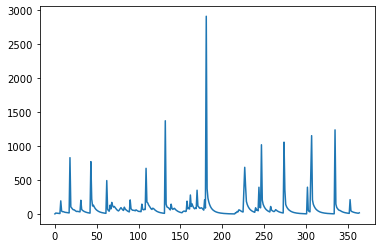

In [12]:
flood_day = q.argmax()
flood_year = flood_day // 365
plt.plot(q[flood_year * 365: (flood_year + 1) * 365])

In [13]:
q.max()

2911.8655468780021

#### Calculate the mean annual sediment load for this river system.

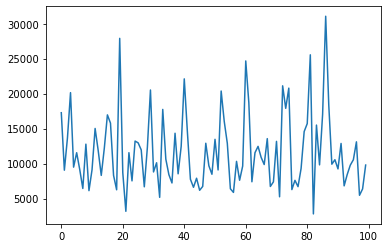

In [14]:
qs_by_year = qs.reshape((-1, 365))
qs_annual = qs_by_year.sum(axis=1)
plt.plot(qs_annual)

In [15]:
qs_annual.mean()

11685.006719835217

#### How does the sediment yield of this river system compare to the present-day Mississippi River?

*To compare the mean annual load to other river systems you will need to calculate its sediment yield. 
Sediment Yield is defined as sediment load normalized for the river drainage area; 
so it can be reported in T/km2/yr.*

## Exercise 2

### How does a river system respond to climate change? A few simple scenarios for the coming century.

#### What happens to river discharge, suspended load and bedload if the mean annual temperature in this specific river basin increases by 4 °C over the next 50 years?

In [35]:
from pymt.models import Hydrotrend
hydrotrend = Hydrotrend()

#### How much increase of discharge do you see after 50 years? How is the average suspended load affected? How does the bedload change? What happens to the peak event; look at the maximum discharge event of the last 10 years of the simulation?